In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

print("Model Mean \n", model_mean)
print("Model Variance \n", model_variance)
print("Model Standard Deviation \n", model_stdev)
print("Model y \n", model_y)
print("Y Value Expected \n", y_exp)

Model Mean 
 tensor([ 2.9781, -6.2484, -5.0409, -7.5745, -1.9715, -0.5310],
       dtype=torch.float64)
Model Variance 
 tensor([7.0451, 6.6657, 6.6158, 7.9149, 5.9327, 5.7718], dtype=torch.float64)
Model Standard Deviation 
 tensor([2.6543, 2.5818, 2.5721, 2.8134, 2.4357, 2.4024], dtype=torch.float64)
Model y 
 tensor([ 2.9781, -6.2484, -5.0409, -7.5745, -1.9715, -0.5310],
       dtype=torch.float64)
Y Value Expected 
 [ 9.70834316e+00 -6.46047881e+00 -3.27150097e+00 -1.18583823e+01
  7.03966099e-03  1.09421370e+00]


In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
# print("best x",best_x)
# print(test_p[1])
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("Best Error is: ",best_error)
print("EI:",ei)

Upper bound is [ 2.6155387   0.          0.77038734 -1.44729424  0.89940208  0.76477084]
Lower bound is [ 2.45571601 -0.16430777  0.60546031 -1.59807903  0.7252387   0.58819668]
pdf upper is [0.01304357 0.39894228 0.29650629 0.13997816 0.26622843 0.29778732]
cdf upper is [0.99554566 0.5        0.77946492 0.07390727 0.81578073 0.77779599]
pdf lower is [0.01956116 0.39359333 0.33212973 0.11126208 0.30668807 0.3355695 ]
cdf lower is [0.99296979 0.43474443 0.7275634  0.0550127  0.7658472  0.72179986]
[0.48390233 0.25       0.35351796 0.07653069 0.36880155 0.35283427]
[0.44978637 0.25       0.12509327 0.27912028 0.12935514 0.12509521]
Best Error is:  0.04498864872895962
EI: [-0.47935579  0.27108409 -0.44025174 -1.3285174  -0.60572062 -0.39335   ]


Lower Improvement Integrand is 
 [0.00000000e+00 0.00000000e+00 2.99599687e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Upper Improvement Integrand is 
 [0. 0. 0. 0. 0. 0.]


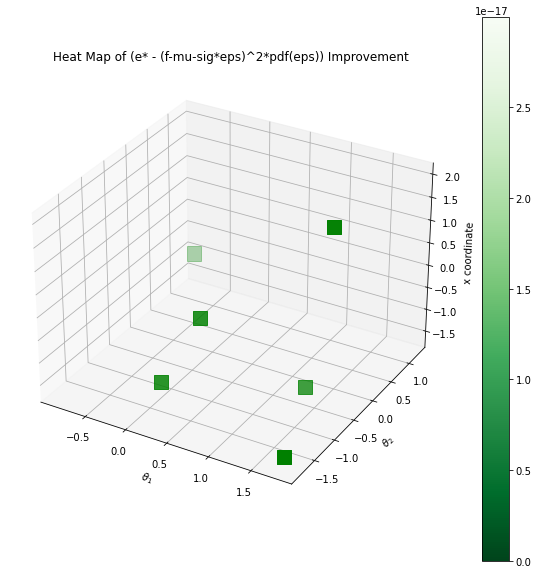

None


In [8]:
Integrand_values = improvement(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )
print(improvement_plot(test_p,Integrand_values))

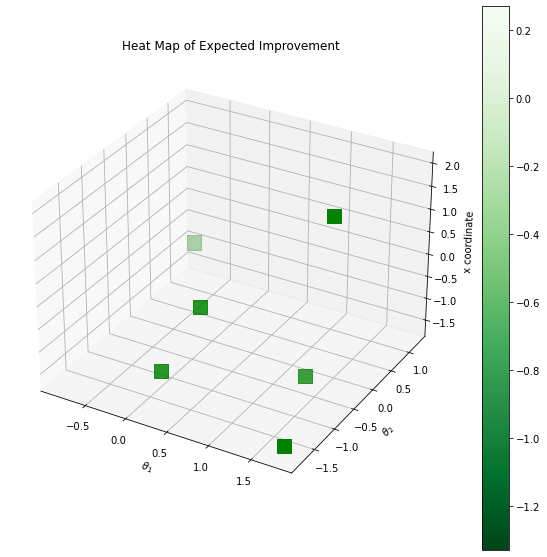

None


In [9]:
print(ei_plotter_adv(test_p, ei))

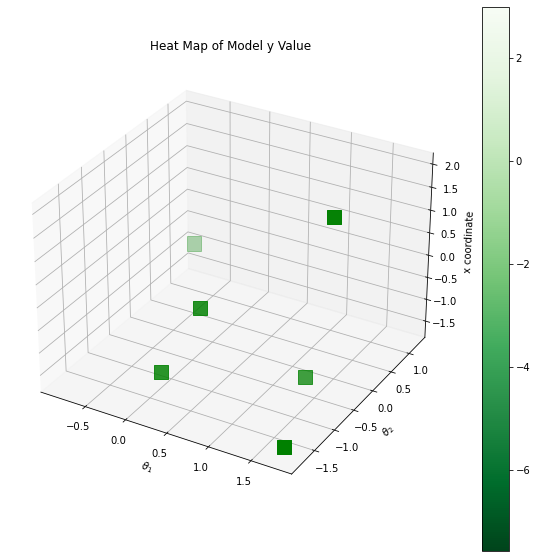

None


In [10]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))